# Generative Classifiers

In [57]:
import jax
from jax import random, jit, vmap
from jax.nn import one_hot
from jax.nn.initializers import glorot_uniform, glorot_normal
from jax.tree_util import tree_map
from jax.scipy.special import logsumexp
from functools import partial # needed to make arguments static in jit compiled code
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import numpy as np
import PIL.Image as pil
from torchvision.datasets import FashionMNIST
from torch.utils import data
from tqdm import tqdm
from tqdm import trange
import optax
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import os
from objax.functional.loss import cross_entropy_logits

In [58]:
# https://github.com/google-deepmind/dm-haiku/issues/18#issuecomment-981814403
MODELS_PATH = "../model/"
def save_models(model, path: str):
    with open(os.path.join(MODELS_PATH, path), "wb") as file:
        pickle.dump(model, file)

In [59]:
# because Apple sucks
jax.default_device = jax.devices("cpu")[0]
jax.default_device

CpuDevice(id=0)

Let's store all the parameters here:

In [60]:
args = {}
args['seed'] = 1
args['batch_size'] = 50
args['learning_rate'] = 1e-4
args['d_epsilon'] = 64
key = random.PRNGKey(args['seed'])
key

Array([0, 1], dtype=uint32)

## Dataloader

- ### FashionMNIST: a realistic dataset

In [61]:
#https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html#data-loading-with-pytorch

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)
  
class TransformImage:
  def __call__(self, image):
    return np.array(image, dtype=jnp.float32).reshape(28, 28, 1)/255.0

In [62]:
fashion_mnist_train_ds = FashionMNIST(
    './data/', 
    download=True,
    train=True,
    transform=TransformImage(),
)
n_train_images = len(fashion_mnist_train_ds.data)
classes = np.unique(fashion_mnist_train_ds.targets)
n_classes = len(classes)

args['n_classes'] = n_classes
args['n_train_images'] = n_train_images

fashion_mnist_test_ds = FashionMNIST(
    './data/', 
    download=True, 
    train=False,
)
n_test_images = len(fashion_mnist_test_ds.data)

# Dataloader used for the training
fashion_mnist_train_dl = NumpyLoader(
    fashion_mnist_train_ds, 
    batch_size=args['batch_size'],
    shuffle=True,
)

# Get the full train dataset (for checking accuracy while training)
#train_images = jnp.array(fashion_mnist_train_ds.data, dtype=jnp.float32).reshape(-1, 28, 28, 1)/255.0
#train_labels = one_hot(jnp.array(fashion_mnist_train_ds.targets, dtype=jnp.float32), n_classes)
#print("train_images", train_images.shape, "train_labels", train_labels.shape)

# Get full test dataset
test_images = jnp.array(fashion_mnist_test_ds.data, dtype=jnp.float32).reshape(-1, 28, 28, 1)/255.0
test_labels = one_hot(jnp.array(fashion_mnist_test_ds.targets, dtype=jnp.float32), n_classes)
print("test_images", test_images.shape, "test_labels", test_labels.shape)

print("n_classes", n_classes)

test_images (10000, 28, 28, 1) test_labels (10000, 10)
n_classes 10


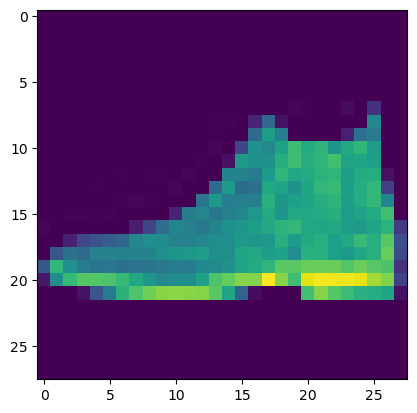

In [63]:
def plot_image(image):
    plt.imshow((image.reshape(28, 28) * 255).astype(np.uint8), interpolation='nearest')
    plt.show()

plot_image(test_images[0,...])

## The model

Our model where $\theta$ and $\phi$ are learnable parameters:

- Let's take the GFZ probabilistic graphical model for a first implementation: $p(x,z,y)=p(z)p(y|z)p(x|z,y)$.

`
q(z|x,y) is the same across all VAE-based classifiers. It starts with a 3-layer
convolutional neural network with 5 ×5 filters and 64 channels, with a max-pooling operation after each convolution. Then,
the convolutional network is followed by a MLP with 2 hidden layers, each with 500 units, to produce the mean and variance
parameters of q. The label y is injected into the MLP at the first hidden layer, as a one hot encoding (i.e. for MNIST, the
first hidden layer has 500+10 units). The latent dimension is dim(z) = 64.
`

In [64]:
def log_gaussian(x, mu=0.0, logsigma=0.0):
    delta = ((x - mu) / jnp.exp(logsigma))**2
    logits = -(0.5*np.log(2*np.pi) + logsigma + 0.5*delta)
    return jnp.sum(logits)

def transform(epsilon, mu, log_sigma):
    sigma = jnp.exp(log_sigma)
    z = mu + sigma * epsilon
    return z

In [65]:
class Log_q_z_xy(nn.Module):
    n_classes = 10
    d_epsilon = 64
    n_convolutions = 3
    n_channels = 64
    kernel_size = (5, 5)
    strides = (2, 2)
    d_hidden = 500

    @nn.compact
    def __call__(self, X, y, epsilon): # X: (height, width), y: (n_classes,), epsilon: (d_epsilon,) -> (d_epsilon,), 0
        for _ in range(self.n_convolutions):
            X = nn.Conv(
                features=self.n_channels, 
                kernel_size=self.kernel_size, 
                strides=self.strides, 
                kernel_init=glorot_normal(),
            )(X)
            X = nn.relu(X)

        X_flatten = X.reshape(-1)
        X_flatten = nn.Dense(
            features=self.d_hidden, 
            use_bias=True,
            kernel_init=glorot_uniform(), 
        )(X_flatten)
        X_flatten = nn.relu(X_flatten)
        
        output = jnp.concatenate((X_flatten, y), axis=0)
        output = nn.Dense(
            features=self.d_hidden, 
            use_bias=False,
            kernel_init=glorot_uniform(), 
        )(output)
        output = nn.relu(output)

        output = nn.Dense(
            features=2*self.d_epsilon, 
            use_bias=True,
            kernel_init=glorot_uniform(), 
        )(output)
        # end of model
        mu, log_sigma = jnp.split(output, 2)
        
        z = transform(epsilon, mu, log_sigma)
        logit = log_gaussian(epsilon)
        return z, logit

In [66]:
X = jnp.ones((28, 28, 1), dtype=jnp.float32)
y = jnp.ones((10,), dtype=jnp.float32)
epsilon = jnp.ones((64), dtype=jnp.float32)
print(Log_q_z_xy().tabulate(key, X, y, epsilon, console_kwargs={"width": 200}))


                                      Log_q_z_xy Summary                                      
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs             ┃ outputs           ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Log_q_z_xy │ - float32[28,28,1] │ - float32[64]     │                            │
│         │            │ - float32[10]      │ - float32[]       │                            │
│         │            │ - float32[64]      │                   │                            │
├─────────┼────────────┼────────────────────┼───────────────────┼────────────────────────────┤
│ Conv_0  │ Conv       │ float32[28,28,1]   │ float32[14,14,64] │ bias: float32[64]          │
│         │            │                    │                   │ kernel: float32[5,5,1,64]  │
│         │            │                    │    

`
For p(y|z) we use a MLP with 1 hidden layer composed of 500 units. For p(x|y,z) we used an MLP with 2
hidden layers, each with 500 units, and 4 ×4 ×64 dimension output, followed by a 3-layer deconvolutional network
with 5 ×5 kernel size, stride 2 and [64, 64, 1] channels.
`

In [67]:
class Log_p_y_z(nn.Module):
    d_hidden = 500
    n_classes = 10

    @nn.compact
    def __call__(self, y, z): # y: (n_classes,), z: (d_epsilon,) -> 0
        logits = nn.Dense(
            features=self.d_hidden, 
            use_bias=True,
            kernel_init=glorot_uniform(), 
        )(z)
        logits = nn.relu(logits)
        logits = nn.Dense(
            features=self.n_classes, 
            use_bias=True,
            kernel_init=glorot_uniform(), 
        )(logits)
        return -cross_entropy_logits(logits, y)

In [68]:
y = jnp.ones((10,), dtype=jnp.float32)
z = jnp.ones((64), dtype=jnp.float32)
print(Log_p_y_z().tabulate(key, y, z, console_kwargs={"width": 200}))


                               Log_p_y_z Summary                                
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs        ┃ outputs      ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Log_p_y_z │ - float32[10] │ float32[]    │                         │
│         │           │ - float32[64] │              │                         │
├─────────┼───────────┼───────────────┼──────────────┼─────────────────────────┤
│ Dense_0 │ Dense     │ float32[64]   │ float32[500] │ bias: float32[500]      │
│         │           │               │              │ kernel: float32[64,500] │
│         │           │               │              │                         │
│         │           │               │              │ 32,500 (130.0 KB)       │
├─────────┼───────────┼───────────────┼──────────────┼─────────────────────────┤
│ Dense_1 │ Dense     │ flo

In [69]:
class Log_p_x_yz(nn.Module):
    d_hidden = 500
    d_epsilon = 64
    n_classes = 10
    n_channels = 64
    input_kernel = (4, 4)
    kernel_size = (5, 5)
    strides = (2, 2)
    

    @nn.compact
    def __call__(self, X, y, z): # X: (height, width), y: (n_classes,), z: (d_epsilon,) -> 0
        inputs = jnp.concatenate([y, z], 0)
        inputs = nn.Dense(
            features=self.d_hidden, 
            use_bias=True,
            kernel_init=glorot_uniform(), 
        )(inputs)
        inputs = nn.relu(inputs)
        inputs = nn.Dense(
            features=np.prod(self.input_kernel) * self.n_channels, 
            use_bias=True,
            kernel_init=glorot_uniform(), 
        )(inputs)
        inputs = nn.relu(inputs)
        
        inputs = inputs.reshape(self.input_kernel + (self.n_channels,))
        inputs = nn.ConvTranspose(
            features=self.n_channels,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=(2, 2),
            kernel_init=glorot_uniform(),
        )(inputs)
        inputs = nn.relu(inputs)

        inputs = nn.ConvTranspose(
            features=self.n_channels,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=((2, 3), (2, 3)),
            kernel_init=glorot_uniform(),
        )(inputs)
        inputs = nn.relu(inputs)

        inputs = nn.ConvTranspose(
            features=1,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=((2, 3), (2, 3)),
            kernel_init=glorot_uniform(),
        )(inputs)
        generated_X = nn.sigmoid(inputs)

        logit = -jnp.sum((generated_X - X)**2)
        return logit

In [70]:
X = jnp.ones((28, 28, 1), dtype=jnp.float32)
y = jnp.ones((10,), dtype=jnp.float32)
z = jnp.ones((64), dtype=jnp.float32)
print(Log_p_x_yz().tabulate(key, X, y, z, console_kwargs={"width": 200}))


                                           Log_p_x_yz Summary                                            
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path            ┃ module        ┃ inputs             ┃ outputs           ┃ params                     ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                 │ Log_p_x_yz    │ - float32[28,28,1] │ float32[]         │                            │
│                 │               │ - float32[10]      │                   │                            │
│                 │               │ - float32[64]      │                   │                            │
├─────────────────┼───────────────┼────────────────────┼───────────────────┼────────────────────────────┤
│ Dense_0         │ Dense         │ float32[74]        │ float32[500]      │ bias: float32[500]         │
│                 │               │          

In [71]:
class ModelGFZ(nn.Module):

    @nn.compact
    def __call__(self, X, y, epsilon): # X: (height, width), y: (n_classes,), epsilon: (d_epsilon,) -> 1, 1
        z, logit_q_z_xy = Log_q_z_xy()(X, y, epsilon)
        logit_p_x_yz = Log_p_x_yz()(X, y, z)
        logit_p_y_z = Log_p_y_z()(y, z)
        return z, logit_q_z_xy, logit_p_x_yz, logit_p_y_z

Here are the loss functions defined in "Auto Encoding Varational Bayes" to approximate the true ELBO $\cal L$:

$$
\widetilde{\cal L}^{A}(\theta,\phi;{\bf x}^{(i)}, {\bf y}^{(i)})=\frac{1}{L}\sum_{l=1}^{L}\log p_{\theta}({\bf x}^{(i)},{\bf z}^{(i,l)},{\bf y}^{(i)})-\log q_{\phi}({\bf z}^{(i,l)}|{\bf x}^{(i)}, {\bf y}^{(i)})
$$

$$

\widetilde{\cal L}^{B}(\theta,\phi;{\bf x}^{(i)}, {\bf y}^{(i)})=-D_{K L}(q_{\phi}({\bf z}|{\bf x}^{(i)}, {\bf y}^{(i)})||p_{\theta}({\bf z}))+\frac{1}{L}\sum_{l=1}^{L} \log p_{\theta}({\bf x}^{(i)}|{\bf z}^{(i,l)}, {\bf y}^{(i)})

$$

$$

\widetilde{\cal L}^{M}(\theta,\phi;{\bf X}^{M}, {\bf y}^{M}, {\bf \epsilon})=\frac{N}{M}\sum_{i=1}^{M}=\widetilde{\cal L}^{A\text{ or }B}(\theta,\phi;{\bf X}^{M}_i, {\bf y}^{M}_i)

$$

Noise distribution $p$ that parameterises latent variable $z$, i.e. $z = g_{\theta}(\epsilon, x, y)$ where $\epsilon\sim p(\epsilon)$.

In [72]:
def sample_p(key, epsilon_shape: tuple) -> np.ndarray:
    key, sample_key = random.split(key)
    epsilon = random.normal(sample_key, epsilon_shape, dtype=jnp.float32)
    return key, epsilon

In [73]:
# ll stands for log-likelyhood
def loss_A_single(z, logit_q_z_xy, logit_p_x_yz, logit_p_y_z):
    logit_p_z = log_gaussian(z)
    ll = logit_p_x_yz + logit_p_y_z + (logit_p_z - logit_q_z_xy)
    return -ll

loss_A = vmap(loss_A_single)

In [74]:
def make_single_prediction(key, model, params, X, K=10):
    epsilon_shape = (n_classes * K, args["d_epsilon"])
    _, epsilon = sample_p(key, epsilon_shape)
    y = one_hot(jnp.repeat(jnp.arange(n_classes), K), n_classes, dtype=jnp.float32)
    z, logit_q_z_xy, logit_p_x_yz, logit_p_y_z = vmap(
        partial(model.apply, {'params': params}),
        in_axes=(None, 0, 0)
    )(X, y, epsilon)

    ll = -loss_A(z, logit_q_z_xy, logit_p_x_yz, logit_p_y_z).reshape(n_classes, K)
    
    p_bayes = nn.softmax(logsumexp(ll, axis=1) - np.log(K))
    y_prediction = jnp.argmax(p_bayes)
    return y_prediction


def make_predictions(key, model, params, X, K=10):
    key, *subkeys = random.split(key, X.shape[0]+1)
    subkeys = jnp.array(subkeys)

    def partial_make_single_prediction(key, x):
        return make_single_prediction(key, model, params, x, K)
    y_predictions = vmap(
        partial_make_single_prediction
    )(subkeys, X)
    return key, y_predictions

In [75]:
def compute_validation_loss(key, model, params, X_test, y_test):
    key, epsilon = sample_p(key, (X_test.shape[0], args["d_epsilon"]))
    z, logit_q_z_xy, logit_p_x_yz, logit_p_y_z = vmap(
        model.apply, 
        in_axes=(None, 0, 0, 0)
    )({"params": params}, X_test, y_test, epsilon)
    loss_value = jnp.mean(
        loss_A(z, logit_q_z_xy, logit_p_x_yz, logit_p_y_z)
    )
    return key, loss_value

def compute_validation_accuracy(key, model, params, X_test, y_test, K=10):
    @jit
    def inner_make_predictions(X):
        return make_predictions(key, model, params, X, K)
    key, y_predictions = inner_make_predictions(X_test)
    labels = jnp.argmax(y_test, axis=1)
    accuracy = jnp.mean(y_predictions == labels) * 100
    return key, accuracy

In [76]:
@jit
def update_step(state, X_batch, y_batch, epsilon):
  def batch_loss(params):
    def loss_fn(X, y, epsilon):
      z, logit_q_z_xy, logit_p_x_yz, logit_p_y_z = state.apply_fn(
        {'params': params},
        X, y, epsilon
      )
      return loss_A_single(z, logit_q_z_xy, logit_p_x_yz, logit_p_y_z)

    loss = jax.vmap(
      loss_fn, 
      in_axes=(0, 0, 0), 
    )(X_batch, y_batch, epsilon)
    return jnp.mean(loss)

  loss, grads = jax.value_and_grad(
    batch_loss,
  )(state.params)

  new_state = state.apply_gradients(
      grads=grads
  )
  return new_state, loss

In [77]:
args['num_epochs'] = 30
args['n_compute_test'] = 100
args['n_train_images'] = n_train_images
args['batch_size'] = 50
args['num_batch'] = args['n_train_images'] // args['batch_size']
args['d_epsilon'] = 64
args['image_size'] = 28

In [78]:
X = jnp.ones((args['image_size'], args['image_size'], 1), dtype=jnp.float32)
y = jnp.ones(args['n_classes'], dtype=jnp.float32)
epsilon = jnp.ones(args['d_epsilon'], dtype=jnp.float32)

model = ModelGFZ()
params = model.init(key, X, y, epsilon)["params"]

training_state = train_state.TrainState.create(
      apply_fn=model.apply,
      params=params,
      tx=optax.adam(args['learning_rate']),
)

In [24]:
# for the test loss logging
n_log_test = 600

#sink for the loss values
training_steps, test_steps = [], []
training_loss_values, test_loss_values, test_accuracy_values = [], [], []

epsilon_shape = (args['batch_size'], args['d_epsilon'])

# training loop
for epoch in range(1, args['num_epochs']+1):
    with tqdm(fashion_mnist_train_dl, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for train_step, (X_batch, y_batch) in enumerate(tepoch):
            # one-hot encoding
            y_batch_one_hot = one_hot(y_batch, n_classes)
            
            # sample from noise distribution
            key, epsilon = sample_p(key, epsilon_shape)

            # training step
            training_state, loss_value = update_step(
                training_state, X_batch, y_batch_one_hot, epsilon
            )
            
            # log the training loss: here it's just the batch loss, need to be fixed.
            training_loss_values.append(loss_value)
            training_steps.append(epoch*args["num_batch"] + train_step+1)

            previous_test_loss = None
            previous_validation_accuracy = None
            if len(test_loss_values) > 0:
                previous_test_loss = test_loss_values[-1]
                previous_test_accuracy = test_accuracy_values[-1]
            tepoch.set_postfix(training_loss=loss_value, test_loss=previous_test_loss, accuracy=previous_validation_accuracy)

            # log the test loss for some steps
            if (train_step+1) % n_log_test == 0:
                key, test_loss_value = compute_validation_loss(
                    key, model, training_state.params, test_images, test_labels
                )

                key, test_accuracy_value = compute_validation_accuracy(
                    key, model, params, test_images, test_labels, K=10
                )

                test_loss_values.append(test_loss_value)

                tepoch.set_postfix(training_loss=loss_value, test_loss=test_loss_value, accuracy=test_accuracy_value)
                test_accuracy_values.append(test_accuracy_value)
                test_steps.append(epoch*args["num_batch"] + train_step+1)

Epoch 5: 100%|██████████| 1200/1200 [04:51<00:00,  4.12batch/s, test_loss=-21.559368, training_loss=-21.295444]


Here is the resulting training/test loss plot:

In [30]:
training_state.params

{'Log_p_x_yz_0': {'ConvTranspose_0': {'bias': Array([-0.0072044 , -0.04772944, -0.01849337, -0.0195586 , -0.02844499,
           0.00307024, -0.01901573, -0.01639657, -0.02554979, -0.03371104,
          -0.00344725,  0.02787227,  0.00463142, -0.00871929,  0.00317438,
           0.00312916, -0.00131236, -0.00450037, -0.02216656,  0.01148971,
          -0.0009421 , -0.00697935, -0.00270326, -0.00602376, -0.00211044,
          -0.00047823, -0.01165605,  0.05544916, -0.01333428, -0.02187807,
          -0.01733948,  0.00202277, -0.03599385, -0.01328802, -0.0308182 ,
          -0.010711  ,  0.02503604, -0.00094873, -0.00431706, -0.03136897,
           0.00500248, -0.01259249, -0.01505468, -0.00183971, -0.00033233,
          -0.00455544, -0.00238372,  0.00971496,  0.00857203, -0.0276675 ,
           0.00377243, -0.02669169,  0.03338969, -0.02586222,  0.00380302,
           0.01292957, -0.00682215,  0.0458863 , -0.04484266,  0.00055852,
           0.00606987,  0.00553377, -0.00374349,  0.00169

In [36]:
import pickle

checkpoint = {"model": training_state.params, "config": args,}

pickle.dump(checkpoint, open('initial-model.pkl', 'wb'))

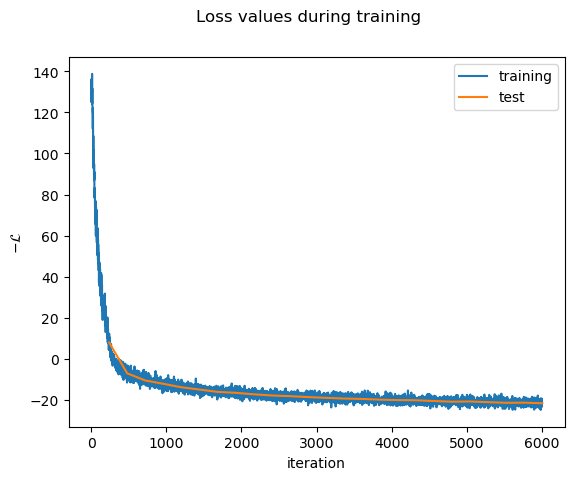

In [45]:
fig, ax = plt.subplots()
ax.plot(training_steps, training_loss_values, label="training")
ax.plot(test_steps, test_loss_values, label="test")
ax.set_xlabel("iteration")
fig.suptitle("Loss values during training")
ax.legend()
_ = ax.set_ylabel("$-\cal L$")

In [13]:
import pickle
initial_model_checkpoint = pickle.load(open('initial-model.pkl', 'rb'))

trained_params = initial_model_checkpoint["model"]

In [81]:
key, subkey = random.split(key)
_, acc = compute_validation_accuracy(subkey, model, trained_params, test_images[:100], test_labels[:100], K=5)
print("Accuracy:", acc)

Accuracy: 19.0
